In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

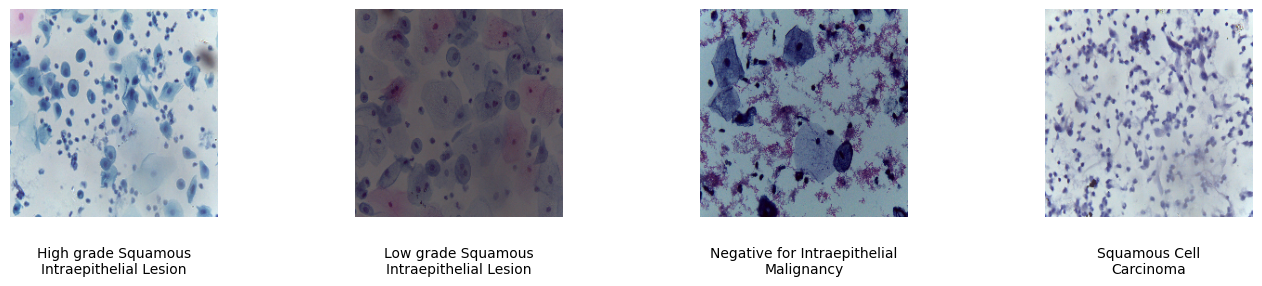

In [1]:
# ===========================
# Display 1 image per Mendeley LBC class (single row) – FIRST image only
# Class name BELOW the image (exact names as in your figure)
# ===========================
import os
import cv2
from glob import glob
import matplotlib.pyplot as plt

# Dataset root (same as your code)
data_root = "/kaggle/input/mendeley-lbc-cervical-cancer"

# Image size (same as training)
image_size = (224, 224)

# Exact class names (match your figure text)
display_order = [
    "High squamous intra-epithelial lesion",
    "Low squamous intra-epithelial lesion",
    "Negative for Intraepithelial malignancy",
    "Squamous cell carcinoma"
]

display_names = {
    "High squamous intra-epithelial lesion": "High grade Squamous\nIntraepithelial Lesion",
    "Low squamous intra-epithelial lesion": "Low grade Squamous\nIntraepithelial Lesion",
    "Negative for Intraepithelial malignancy": "Negative for Intraepithelial\nMalignancy",
    "Squamous cell carcinoma": "Squamous Cell\nCarcinoma"
}

# Plot
fig, axes = plt.subplots(1, 4, figsize=(14, 3))

for i, cls in enumerate(display_order):
    folder_path = os.path.join(data_root, cls)
    img_list = sorted(glob(os.path.join(folder_path, "*.jpg")))

    if len(img_list) == 0:
        raise FileNotFoundError(f"No .jpg images found in: {folder_path}")

    # Pick the FIRST image (deterministic)
    img_path = img_list[0]

    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Failed to read image: {img_path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, image_size)

    axes[i].imshow(img)
    axes[i].axis("off")

    # Label BELOW the image
    axes[i].text(
        0.5, -0.14,
        display_names[cls],
        fontsize=10,
        ha="center",
        va="top",
        transform=axes[i].transAxes
    )


plt.tight_layout()
plt.show()


In [2]:
# ============================================================
# ✅ MENDELEY LBC DATASET (4 classes)
# ✅ 5-Fold Stratified Cross-Validation
# ✅ Models: AlexNet, ResNet50, EfficientNet-B0, CNN-Transformer Hybrid
# ✅ Per-epoch (per fold) logging: Train Loss, Val Acc, Val F1
# ✅ Final metrics (per fold + mean±std): Acc, Macro-F1, Sens, Spec, AUC
# ✅ Inference time per image (ms/img) for each fold + mean±std
# ✅ Significance testing: Wilcoxon signed-rank (best-by-mean-Acc vs others)
# ✅ Multiple comparisons correction: Holm
# ============================================================

# =========================================
# 📦 Imports
# =========================================
import os
import cv2
import time
import numpy as np
from glob import glob

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torchvision import models
from timm import create_model

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score,
    confusion_matrix, roc_auc_score
)

# stats
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

# =========================================
# ⚙️ Reproducibility
# =========================================
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # deterministic (can slow down a bit)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# =========================================
# ⚙️ Device
# =========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =========================================
# 📊 Load Mendeley LBC Dataset
# =========================================
data_root = "/kaggle/input/mendeley-lbc-cervical-cancer"

cell_types = [
    "High squamous intra-epithelial lesion",
    "Low squamous intra-epithelial lesion",
    "Negative for Intraepithelial malignancy",
    "Squamous cell carcinoma"
]
class_names = cell_types
num_classes = len(cell_types)
image_size = (224, 224)

X, y = [], []
label_map = {name: idx for idx, name in enumerate(cell_types)}

for cell_type in cell_types:
    folder_path = os.path.join(data_root, cell_type)
    images = glob(os.path.join(folder_path, "*.jpg"))
    print(f"Loading {len(images)} images from '{cell_type}'...")

    for img_path in images:
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, image_size)
        X.append(img)
        y.append(label_map[cell_type])

X = np.array(X, dtype=np.float32) / 255.0
y = np.array(y, dtype=np.int64)

print("\n✅ Dataset Loaded Successfully!")
print("X:", X.shape, X.dtype)
print("y:", y.shape, y.dtype)
print("Class mapping:", label_map)

# ============================================================
# 🔀 CNN–Transformer Hybrid
# ============================================================
class CNNTransformerHybrid(nn.Module):
    def __init__(self, num_classes=4, embed_dim=256, num_heads=4, num_layers=2):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56
            nn.Conv2d(128, embed_dim, 3, padding=1), nn.BatchNorm2d(embed_dim), nn.ReLU(),
            nn.MaxPool2d(4)   # 14x14
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            batch_first=True,
            dropout=0.1
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.cnn(x)                    # [B, C, H, W]
        x = x.flatten(2).transpose(1, 2)   # [B, HW, C]
        x = self.transformer(x)            # [B, HW, C]
        x = x.transpose(1, 2)              # [B, C, HW]
        x = self.avgpool(x).squeeze(-1)    # [B, C]
        return self.fc(x)                  # [B, num_classes]

# =========================================
# 🧠 Model Initialization
# =========================================
def initialize_model(model_name, num_classes):
    if model_name == "alexnet":
        model = models.alexnet(weights="IMAGENET1K_V1")
        model.classifier[6] = nn.Linear(4096, num_classes)

    elif model_name == "resnet50":
        model = models.resnet50(weights="IMAGENET1K_V1")
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "efficientnet_b0":
        model = create_model("efficientnet_b0", pretrained=True, num_classes=num_classes)

    elif model_name == "cnn_transformer":
        model = CNNTransformerHybrid(num_classes=num_classes)

    else:
        raise ValueError(f"Unknown model name: {model_name}")

    return model.to(device)

# =========================================
# 📐 Metrics
# =========================================
def compute_specificity_macro(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
    spec_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        spec_list.append(tn / (tn + fp + 1e-8))
    return float(np.mean(spec_list))

def compute_metrics(y_true, y_pred, y_prob, num_classes):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    sens = recall_score(y_true, y_pred, average="macro")
    spec = compute_specificity_macro(y_true, y_pred, num_classes)

    # requires probabilities that sum to 1 across classes (softmax)
    auc = roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro")
    return acc, f1m, sens, spec, auc

# =========================================
# ⏱️ Inference Time (ms/img)
# =========================================
def measure_inference_time_ms(model, loader):
    model.eval()
    total_time, total_images = 0.0, 0
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            start = time.time()
            _ = model(images)
            total_time += (time.time() - start)
            total_images += images.size(0)
    return (total_time / max(total_images, 1)) * 1000.0

# =========================================
# 🧱 Training Loop with Epoch-wise logging
# Early stopping on Val Macro-F1
# =========================================
def train_one_fold(model, train_loader, val_loader, fold_id,
                   epochs=30, patience=5, lr=1e-4, model_name="model"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_f1 = -1.0
    best_weights = None
    patience_ctr = 0

    for epoch in range(epochs):
        # ---- Train ----
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        train_loss = running_loss / len(train_loader.dataset)

        # ---- Validate ----
        model.eval()
        preds, gt = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                outputs = model(images)
                preds.extend(torch.argmax(outputs, 1).cpu().numpy())
                gt.extend(labels.numpy())

        val_acc = accuracy_score(gt, preds)
        val_f1 = f1_score(gt, preds, average="macro")

        print(
            f"[{model_name} | Fold {fold_id}] Epoch [{epoch+1:02d}/{epochs}] | "
            f"Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}"
        )

        # ---- Early stopping on F1 ----
        if val_f1 > best_f1 + 1e-6:
            best_f1 = val_f1
            # keep a deep copy on CPU to avoid reference issues
            best_weights = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            patience_ctr = 0
        else:
            patience_ctr += 1

        if patience_ctr >= patience:
            print(f"⏹️ Early stopping at epoch {epoch+1} (Fold {fold_id})")
            break

    if best_weights is None:
        best_weights = model.state_dict()

    model.load_state_dict(best_weights)
    return model

# ============================================================
# 🔁 5-FOLD CV RUN (ALL MODELS) + STORE FOLD SCORES
# ============================================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models_to_train = ["alexnet", "resnet50", "efficientnet_b0", "cnn_transformer"]

# store fold-wise results for significance tests
fold_scores = {m: {"Accuracy": [], "MacroF1": [], "Sensitivity": [], "Specificity": [], "AUC": []}
               for m in models_to_train}
fold_inference = {m: [] for m in models_to_train}

for model_name in models_to_train:
    print(f"\n{'='*22} {model_name.upper()} | 5-FOLD CV {'='*22}")

    fold_metrics = []
    fold_inference_ms = []

    for fold, (tr_idx, te_idx) in enumerate(skf.split(X, y), start=1):
        print(f"\n🔁 Starting Fold {fold}/5")

        X_tr, X_te = X[tr_idx], X[te_idx]
        y_tr, y_te = y[tr_idx], y[te_idx]

        # tensors: (N, C, H, W)
        X_tr_t = torch.tensor(X_tr).permute(0, 3, 1, 2)
        X_te_t = torch.tensor(X_te).permute(0, 3, 1, 2)
        y_tr_t = torch.tensor(y_tr, dtype=torch.long)
        y_te_t = torch.tensor(y_te, dtype=torch.long)

        train_loader = DataLoader(TensorDataset(X_tr_t, y_tr_t),
                                  batch_size=32, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_te_t, y_te_t),
                                batch_size=32, shuffle=False)

        # init + train
        model = initialize_model(model_name, num_classes)
        model = train_one_fold(model, train_loader, val_loader,
                               fold_id=fold, epochs=30, patience=5, lr=1e-4,
                               model_name=model_name)

        # ---- Final evaluation for this fold ----
        model.eval()
        preds, gt, probs_all = [], [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                outputs = model(images)
                probs = torch.softmax(outputs, 1).cpu().numpy()

                preds.extend(torch.argmax(outputs, 1).cpu().numpy())
                probs_all.extend(probs)
                gt.extend(labels.numpy())

        gt = np.array(gt, dtype=np.int64)
        preds = np.array(preds, dtype=np.int64)
        probs_all = np.array(probs_all, dtype=np.float32)

        acc, f1m, sens, spec, auc = compute_metrics(gt, preds, probs_all, num_classes)
        inf_ms = measure_inference_time_ms(model, val_loader)

        fold_metrics.append([acc, f1m, sens, spec, auc])
        fold_inference_ms.append(inf_ms)

        # store for later Wilcoxon
        fold_scores[model_name]["Accuracy"].append(acc)
        fold_scores[model_name]["MacroF1"].append(f1m)
        fold_scores[model_name]["Sensitivity"].append(sens)
        fold_scores[model_name]["Specificity"].append(spec)
        fold_scores[model_name]["AUC"].append(auc)
        fold_inference[model_name].append(inf_ms)

        print(
            f"✅ Fold {fold} Result | "
            f"Acc={acc:.4f} | F1={f1m:.4f} | Sens={sens:.4f} | Spec={spec:.4f} | AUC={auc:.4f} | "
            f"Inf ms/img={inf_ms:.2f}"
        )

    fold_metrics = np.array(fold_metrics, dtype=np.float64)
    mean = fold_metrics.mean(axis=0)
    std = fold_metrics.std(axis=0)

    inf_mean = float(np.mean(fold_inference_ms))
    inf_std = float(np.std(fold_inference_ms))

    print(f"\n📌 {model_name.upper()} — Mean ± Std (5-Fold CV)")
    print(f"Accuracy:     {mean[0]:.4f} ± {std[0]:.4f}")
    print(f"Macro F1:     {mean[1]:.4f} ± {std[1]:.4f}")
    print(f"Sensitivity:  {mean[2]:.4f} ± {std[2]:.4f}")
    print(f"Specificity:  {mean[3]:.4f} ± {std[3]:.4f}")
    print(f"AUC:          {mean[4]:.4f} ± {std[4]:.4f}")
    print(f"Inference ms/img: {inf_mean:.2f} ± {inf_std:.2f}")

print("\n✅ ALL MODELS COMPLETED (MENDELEY LBC)")

# ============================================================
# ✅ SIGNIFICANCE TESTING
#    1) Pick best model by mean Accuracy across folds
#    2) Wilcoxon signed-rank test (paired by fold) vs each other model
#    3) Holm correction for multiple comparisons
# ============================================================
primary_metric = "Accuracy"  # reviewer-friendly; switch to "MacroF1" if you prefer

mean_accs = {m: float(np.mean(fold_scores[m][primary_metric])) for m in models_to_train}
best_model = max(mean_accs, key=mean_accs.get)

print("\n================= BEST MODEL SELECTION =================")
for m, v in mean_accs.items():
    print(f"{m}: mean {primary_metric} = {v:.6f}")
print(f"✅ Best model by mean {primary_metric}: {best_model.upper()}")

best_vec = np.array(fold_scores[best_model][primary_metric], dtype=np.float64)

comparisons, pvals, wstats = [], [], []
for m in models_to_train:
    if m == best_model:
        continue
    other_vec = np.array(fold_scores[m][primary_metric], dtype=np.float64)

    # Wilcoxon signed-rank test on paired folds
    # NOTE: with only 5 folds, p-values are coarse; still acceptable for reviewer request
    stat, p = wilcoxon(best_vec, other_vec, zero_method="wilcox", alternative="two-sided", mode="auto")

    comparisons.append(f"{best_model} vs {m}")
    pvals.append(p)
    wstats.append(stat)

print("\n================= WILCOXON (paired folds) =================")
print(f"Metric used for testing: {primary_metric}")
for c, s, p in zip(comparisons, wstats, pvals):
    print(f"{c}: W={s:.4f}, p={p:.6f}")

# Holm correction
reject, pvals_holm, _, _ = multipletests(pvals, alpha=0.05, method="holm")

print("\n=========== HOLM-CORRECTED (family-wise) ===========")
for c, p_raw, p_adj, r in zip(comparisons, pvals, pvals_holm, reject):
    print(f"{c}: p_raw={p_raw:.6f} | p_holm={p_adj:.6f} | significant={bool(r)}")


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Using device: cuda
Loading 163 images from 'High squamous intra-epithelial lesion'...
Loading 113 images from 'Low squamous intra-epithelial lesion'...
Loading 612 images from 'Negative for Intraepithelial malignancy'...
Loading 74 images from 'Squamous cell carcinoma'...

✅ Dataset Loaded Successfully!
X: (962, 224, 224, 3) float32
y: (962,) int64
Class mapping: {'High squamous intra-epithelial lesion': 0, 'Low squamous intra-epithelial lesion': 1, 'Negative for Intraepithelial malignancy': 2, 'Squamous cell carcinoma': 3}

====================== ALEXNET | 5-FOLD CV ======================

🔁 Starting Fold 1/5


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 201MB/s]  


[alexnet | Fold 1] Epoch [01/30] | Train Loss: 0.6189 | Val Acc: 0.8497 | Val F1: 0.6007
[alexnet | Fold 1] Epoch [02/30] | Train Loss: 0.3610 | Val Acc: 0.8290 | Val F1: 0.5860
[alexnet | Fold 1] Epoch [03/30] | Train Loss: 0.1962 | Val Acc: 0.9637 | Val F1: 0.9209
[alexnet | Fold 1] Epoch [04/30] | Train Loss: 0.0977 | Val Acc: 0.9585 | Val F1: 0.9148
[alexnet | Fold 1] Epoch [05/30] | Train Loss: 0.0476 | Val Acc: 0.9689 | Val F1: 0.9260
[alexnet | Fold 1] Epoch [06/30] | Train Loss: 0.0476 | Val Acc: 0.9016 | Val F1: 0.8351
[alexnet | Fold 1] Epoch [07/30] | Train Loss: 0.1451 | Val Acc: 0.9741 | Val F1: 0.9452
[alexnet | Fold 1] Epoch [08/30] | Train Loss: 0.0533 | Val Acc: 0.9534 | Val F1: 0.9026
[alexnet | Fold 1] Epoch [09/30] | Train Loss: 0.0304 | Val Acc: 0.9637 | Val F1: 0.9233
[alexnet | Fold 1] Epoch [10/30] | Train Loss: 0.0171 | Val Acc: 0.9689 | Val F1: 0.9390
[alexnet | Fold 1] Epoch [11/30] | Train Loss: 0.0207 | Val Acc: 0.9689 | Val F1: 0.9390
[alexnet | Fold 1] Ep

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s] 


[resnet50 | Fold 1] Epoch [01/30] | Train Loss: 0.2899 | Val Acc: 0.8601 | Val F1: 0.7270
[resnet50 | Fold 1] Epoch [02/30] | Train Loss: 0.0561 | Val Acc: 0.9741 | Val F1: 0.9324
[resnet50 | Fold 1] Epoch [03/30] | Train Loss: 0.0589 | Val Acc: 0.9793 | Val F1: 0.9473
[resnet50 | Fold 1] Epoch [04/30] | Train Loss: 0.0404 | Val Acc: 0.9845 | Val F1: 0.9654
[resnet50 | Fold 1] Epoch [05/30] | Train Loss: 0.0332 | Val Acc: 0.9637 | Val F1: 0.9230
[resnet50 | Fold 1] Epoch [06/30] | Train Loss: 0.0111 | Val Acc: 0.9896 | Val F1: 0.9748
[resnet50 | Fold 1] Epoch [07/30] | Train Loss: 0.0043 | Val Acc: 0.9948 | Val F1: 0.9876
[resnet50 | Fold 1] Epoch [08/30] | Train Loss: 0.0143 | Val Acc: 0.9896 | Val F1: 0.9766
[resnet50 | Fold 1] Epoch [09/30] | Train Loss: 0.0175 | Val Acc: 0.9741 | Val F1: 0.9324
[resnet50 | Fold 1] Epoch [10/30] | Train Loss: 0.0316 | Val Acc: 0.9741 | Val F1: 0.9501
[resnet50 | Fold 1] Epoch [11/30] | Train Loss: 0.0372 | Val Acc: 0.9793 | Val F1: 0.9590
[resnet50 

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

[efficientnet_b0 | Fold 1] Epoch [01/30] | Train Loss: 1.3403 | Val Acc: 0.5855 | Val F1: 0.4807
[efficientnet_b0 | Fold 1] Epoch [02/30] | Train Loss: 0.0613 | Val Acc: 0.9741 | Val F1: 0.9481
[efficientnet_b0 | Fold 1] Epoch [03/30] | Train Loss: 0.0204 | Val Acc: 0.9896 | Val F1: 0.9813
[efficientnet_b0 | Fold 1] Epoch [04/30] | Train Loss: 0.0380 | Val Acc: 0.9845 | Val F1: 0.9629
[efficientnet_b0 | Fold 1] Epoch [05/30] | Train Loss: 0.0162 | Val Acc: 0.9793 | Val F1: 0.9562
[efficientnet_b0 | Fold 1] Epoch [06/30] | Train Loss: 0.0127 | Val Acc: 0.9845 | Val F1: 0.9643
[efficientnet_b0 | Fold 1] Epoch [07/30] | Train Loss: 0.0067 | Val Acc: 0.9896 | Val F1: 0.9766
[efficientnet_b0 | Fold 1] Epoch [08/30] | Train Loss: 0.0051 | Val Acc: 0.9845 | Val F1: 0.9629
⏹️ Early stopping at epoch 8 (Fold 1)
✅ Fold 1 Result | Acc=0.9896 | F1=0.9813 | Sens=0.9813 | Spec=0.9970 | AUC=0.9994 | Inf ms/img=0.32

🔁 Starting Fold 2/5
[efficientnet_b0 | Fold 2] Epoch [01/30] | Train Loss: 1.8312 | V

/usr/local/lib/python3.11/dist-packages/scipy/stats/_wilcoxon.py:134: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=-1)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_wilcoxon.py:135: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=-1)



=========== HOLM-CORRECTED (family-wise) ===========
resnet50 vs alexnet: p_raw=0.125000 | p_holm=0.250000 | significant=False
resnet50 vs efficientnet_b0: p_raw=0.125000 | p_holm=0.250000 | significant=False
resnet50 vs cnn_transformer: p_raw=0.062500 | p_holm=0.187500 | significant=False


In [3]:
# ============================================================
# ✅ MENDELEY LBC DATASET (4 classes)
# ✅ 5-Fold Stratified Cross-Validation
# ✅ Models: AlexNet, ResNet50, EfficientNet-B0, CNN-Transformer Hybrid
# ✅ Per-epoch (per fold) logging: Train Loss, Val Acc, Val F1
# ✅ Final metrics (per fold + mean±std): Acc, Macro-F1, Sens, Spec, AUC
# ✅ Inference time per image (ms/img) for each fold + mean±std
# ============================================================

# =========================================
# 📦 Imports
# =========================================
import os
import cv2
import time
import numpy as np
from glob import glob

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torchvision import models
from timm import create_model

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score,
    confusion_matrix, roc_auc_score
)

# =========================================
# ⚙️ Reproducibility
# =========================================
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# =========================================
# ⚙️ Device
# =========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =========================================
# 📊 Load Mendeley LBC Dataset
# =========================================
data_root = "/kaggle/input/mendeley-lbc-cervical-cancer"

cell_types = [
    "High squamous intra-epithelial lesion",
    "Low squamous intra-epithelial lesion",
    "Negative for Intraepithelial malignancy",
    "Squamous cell carcinoma"
]
class_names = cell_types
num_classes = len(cell_types)
image_size = (224, 224)

X, y = [], []
label_map = {name: idx for idx, name in enumerate(cell_types)}

for cell_type in cell_types:
    folder_path = os.path.join(data_root, cell_type)
    images = glob(os.path.join(folder_path, "*.jpg"))
    print(f"Loading {len(images)} images from '{cell_type}'...")

    for img_path in images:
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, image_size)
        X.append(img)
        y.append(label_map[cell_type])

X = np.array(X, dtype=np.float32) / 255.0
y = np.array(y, dtype=np.int64)

print("\n✅ Dataset Loaded Successfully!")
print("X:", X.shape, X.dtype)
print("y:", y.shape, y.dtype)
print("Class mapping:", label_map)

# ============================================================
# 🔀 CNN–Transformer Hybrid (FIXED)
# ============================================================
class CNNTransformerHybrid(nn.Module):
    """
    A simple hybrid:
      - CNN stem for local texture
      - Flatten -> tokens
      - Transformer encoder for global context
      - FC head for classification
    """
    def __init__(self, num_classes=4, embed_dim=256, num_heads=4, num_layers=2):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56
            nn.Conv2d(128, embed_dim, 3, padding=1), nn.BatchNorm2d(embed_dim), nn.ReLU(),
            nn.MaxPool2d(4)   # 14x14
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            batch_first=True,
            dropout=0.1
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.cnn(x)                    # [B, C, H, W]
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)   # [B, HW, C]
        x = self.transformer(x)            # [B, HW, C]
        x = x.transpose(1, 2)              # [B, C, HW]
        x = self.avgpool(x).squeeze(-1)    # [B, C]
        return self.fc(x)                  # [B, num_classes]

# =========================================
# 🧠 Model Initialization
# =========================================
def initialize_model(model_name, num_classes):
    if model_name == "alexnet":
        model = models.alexnet(weights="IMAGENET1K_V1")
        model.classifier[6] = nn.Linear(4096, num_classes)

    elif model_name == "resnet50":
        model = models.resnet50(weights="IMAGENET1K_V1")
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif model_name == "efficientnet_b0":
        model = create_model("efficientnet_b0", pretrained=True, num_classes=num_classes)

    elif model_name == "cnn_transformer":
        model = CNNTransformerHybrid(num_classes=num_classes)

    else:
        raise ValueError("Unknown model name")

    return model.to(device)

# =========================================
# 📐 Metrics
# =========================================
def compute_metrics(y_true, y_pred, y_prob, num_classes):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")
    sensitivity = recall_score(y_true, y_pred, average="macro")

    cm = confusion_matrix(y_true, y_pred)
    spec_list = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        spec_list.append(tn / (tn + fp + 1e-8))
    specificity = float(np.mean(spec_list))

    auc = roc_auc_score(
        y_true,
        y_prob,
        multi_class="ovr",
        average="macro"
    )
    return acc, f1, sensitivity, specificity, auc

# =========================================
# ⏱️ Inference Time (ms/img)
# =========================================
def measure_inference_time_ms(model, loader):
    model.eval()
    total_time, total_images = 0.0, 0
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            start = time.time()
            _ = model(images)
            total_time += (time.time() - start)
            total_images += images.size(0)
    return (total_time / total_images) * 1000.0

# =========================================
# 🧱 Training Loop with Epoch-wise logging
# Early stopping is based on Val Macro-F1 (stronger than Acc)
# =========================================
def train_one_fold(model, train_loader, val_loader, fold_id,
                   epochs=30, patience=5, lr=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_f1 = -1.0
    best_weights = None
    patience_ctr = 0

    for epoch in range(epochs):
        # ---- Train ----
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        train_loss = running_loss / len(train_loader.dataset)

        # ---- Validate ----
        model.eval()
        preds, gt, probs_all = [], [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                outputs = model(images)
                probs = torch.softmax(outputs, 1).cpu().numpy()

                preds.extend(torch.argmax(outputs, 1).cpu().numpy())
                probs_all.extend(probs)
                gt.extend(labels.numpy())

        val_acc = accuracy_score(gt, preds)
        val_f1 = f1_score(gt, preds, average="macro")

        print(
            f"[Fold {fold_id}] Epoch [{epoch+1:02d}/{epochs}] | "
            f"Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}"
        )

        # ---- Early stopping on F1 ----
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_weights = model.state_dict()
            patience_ctr = 0
        else:
            patience_ctr += 1

        if patience_ctr >= patience:
            print(f"⏹️ Early stopping at epoch {epoch+1} (Fold {fold_id})")
            break

    model.load_state_dict(best_weights)
    return model

# ============================================================
# 🔁 5-FOLD CV RUN (ALL 4 MODELS)
# ============================================================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models_to_train = ["alexnet", "resnet50", "efficientnet_b0", "cnn_transformer"]

for model_name in models_to_train:
    print(f"\n{'='*22} {model_name.upper()} | 5-FOLD CV {'='*22}")

    fold_metrics = []
    fold_inference_ms = []

    for fold, (tr_idx, te_idx) in enumerate(skf.split(X, y), start=1):
        print(f"\n🔁 Starting Fold {fold}/5")

        X_tr, X_te = X[tr_idx], X[te_idx]
        y_tr, y_te = y[tr_idx], y[te_idx]

        # tensors: (N, C, H, W)
        X_tr_t = torch.tensor(X_tr).permute(0, 3, 1, 2)
        X_te_t = torch.tensor(X_te).permute(0, 3, 1, 2)
        y_tr_t = torch.tensor(y_tr, dtype=torch.long)
        y_te_t = torch.tensor(y_te, dtype=torch.long)

        train_loader = DataLoader(
            TensorDataset(X_tr_t, y_tr_t),
            batch_size=32,
            shuffle=True
        )
        val_loader = DataLoader(
            TensorDataset(X_te_t, y_te_t),
            batch_size=32,
            shuffle=False
        )

        # init + train
        model = initialize_model(model_name, num_classes)
        model = train_one_fold(
            model,
            train_loader,
            val_loader,
            fold_id=fold,
            epochs=30,
            patience=5,
            lr=1e-4
        )

        # ---- Final evaluation for this fold ----
        model.eval()
        preds, gt, probs_all = [], [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                outputs = model(images)
                probs = torch.softmax(outputs, 1).cpu().numpy()

                preds.extend(torch.argmax(outputs, 1).cpu().numpy())
                probs_all.extend(probs)
                gt.extend(labels.numpy())

        gt = np.array(gt)
        preds = np.array(preds)
        probs_all = np.array(probs_all)

        acc, f1m, sens, spec, auc = compute_metrics(gt, preds, probs_all, num_classes)
        inf_ms = measure_inference_time_ms(model, val_loader)

        fold_metrics.append([acc, f1m, sens, spec, auc])
        fold_inference_ms.append(inf_ms)

        print(
            f"✅ Fold {fold} Result | "
            f"Acc={acc:.4f} | F1={f1m:.4f} | Sens={sens:.4f} | Spec={spec:.4f} | AUC={auc:.4f} | "
            f"Inf ms/img={inf_ms:.2f}"
        )

    fold_metrics = np.array(fold_metrics, dtype=np.float64)
    mean = fold_metrics.mean(axis=0)
    std = fold_metrics.std(axis=0)

    inf_mean = float(np.mean(fold_inference_ms))
    inf_std = float(np.std(fold_inference_ms))

    print(f"\n📌 {model_name.upper()} — Mean ± Std (5-Fold CV)")
    print(f"Accuracy:     {mean[0]:.4f} ± {std[0]:.4f}")
    print(f"Macro F1:     {mean[1]:.4f} ± {std[1]:.4f}")
    print(f"Sensitivity:  {mean[2]:.4f} ± {std[2]:.4f}")
    print(f"Specificity:  {mean[3]:.4f} ± {std[3]:.4f}")
    print(f"AUC:          {mean[4]:.4f} ± {std[4]:.4f}")
    print(f"Inference ms/img: {inf_mean:.2f} ± {inf_std:.2f}")

print("\n✅ ALL MODELS COMPLETED (MENDELEY LBC)")


Using device: cuda
Loading 163 images from 'High squamous intra-epithelial lesion'...
Loading 113 images from 'Low squamous intra-epithelial lesion'...
Loading 612 images from 'Negative for Intraepithelial malignancy'...
Loading 74 images from 'Squamous cell carcinoma'...

✅ Dataset Loaded Successfully!
X: (962, 224, 224, 3) float32
y: (962,) int64
Class mapping: {'High squamous intra-epithelial lesion': 0, 'Low squamous intra-epithelial lesion': 1, 'Negative for Intraepithelial malignancy': 2, 'Squamous cell carcinoma': 3}

====================== ALEXNET | 5-FOLD CV ======================

🔁 Starting Fold 1/5
[Fold 1] Epoch [01/30] | Train Loss: 0.6189 | Val Acc: 0.8497 | Val F1: 0.6007
[Fold 1] Epoch [02/30] | Train Loss: 0.3610 | Val Acc: 0.8290 | Val F1: 0.5860
[Fold 1] Epoch [03/30] | Train Loss: 0.1962 | Val Acc: 0.9637 | Val F1: 0.9209
[Fold 1] Epoch [04/30] | Train Loss: 0.0977 | Val Acc: 0.9585 | Val F1: 0.9148
[Fold 1] Epoch [05/30] | Train Loss: 0.0476 | Val Acc: 0.9689 | Va

KeyboardInterrupt: 

In [1]:
# ============================================================
# ✅ MENDELEY LBC (ML BASELINES) — 5-FOLD CV + NEW METRICS
# ✅ Features: HOG, LBP, SIFT-BoVW
# ✅ Models: Logistic Regression, Random Forest, Linear SVM
# ✅ Metrics: Acc, Macro-F1, Sensitivity, Specificity, AUC (macro OVR)
# ✅ Inference time: ms/img
# ✅ IMPORTANT: SIFT codebook built per fold to avoid leakage
# ============================================================

# =========================================
# 📦 Imports
# =========================================
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2gray

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.cluster import MiniBatchKMeans

from sklearn.metrics import (
    accuracy_score, f1_score, recall_score,
    confusion_matrix, roc_auc_score
)

# =========================================
# ⚙️ Reproducibility
# =========================================
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)

set_seed(42)

# =========================================
# 📊 Load Mendeley LBC Dataset
# =========================================
data_root = "/kaggle/input/mendeley-lbc-cervical-cancer"

cell_types = [
    "High squamous intra-epithelial lesion",
    "Low squamous intra-epithelial lesion",
    "Negative for Intraepithelial malignancy",
    "Squamous cell carcinoma"
]
class_names = cell_types
label_map = {name: idx for idx, name in enumerate(cell_types)}
num_classes = len(cell_types)

image_size = (224, 224)

X, y = [], []

for cell_type in cell_types:
    folder_path = os.path.join(data_root, cell_type)
    images = glob(os.path.join(folder_path, "*.jpg"))
    print(f"Loading {len(images)} images from '{cell_type}'...")

    for img_path in images:
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, image_size)
        X.append(img)
        y.append(label_map[cell_type])

X = np.array(X, dtype=np.float32) / 255.0
y = np.array(y, dtype=np.int64)

print("\n✅ Dataset Loaded!")
print("X:", X.shape, X.dtype)
print("y:", y.shape, y.dtype)
print("Label map:", label_map)

# =========================================
# 🧠 ML Models
# =========================================
def make_models():
    return {
        "Logistic Regression": LogisticRegression(max_iter=500, solver="liblinear"),
        "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
        "Linear SVM": LinearSVC(max_iter=5000, random_state=42)
    }

# =========================================
# 📐 Metrics Helpers
# =========================================
def compute_specificity_macro(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred)
    specs = []
    for i in range(num_classes):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specs.append(tn / (tn + fp + 1e-8))
    return float(np.mean(specs))

def softmax_np(z):
    z = z - np.max(z, axis=1, keepdims=True)
    e = np.exp(z)
    return e / (e.sum(axis=1, keepdims=True) + 1e-12)

def get_scores_for_auc(model, X_fold):
    """
    Return y_score as probabilities (N, C) to keep roc_auc_score happy.
    - LR/RF: predict_proba -> already prob
    - LinearSVC: decision_function -> convert to prob via softmax
    """
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_fold)
        # numerical safety
        proba = proba / (proba.sum(axis=1, keepdims=True) + 1e-12)
        return proba

    if hasattr(model, "decision_function"):
        scores = model.decision_function(X_fold)

        # binary edge case: (N,) -> convert to (N,2)
        if scores.ndim == 1:
            scores = np.vstack([-scores, scores]).T

        # multiclass: (N,C) -> softmax to get pseudo-probabilities
        proba = softmax_np(scores)
        return proba

    raise ValueError("Model does not support scoring for AUC.")


def compute_metrics(y_true, y_pred, y_score, num_classes):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    sens = recall_score(y_true, y_pred, average="macro")  # macro sensitivity
    spec = compute_specificity_macro(y_true, y_pred, num_classes)
    auc = roc_auc_score(y_true, y_score, multi_class="ovr", average="macro")
    return acc, f1m, sens, spec, auc

def inference_time_ms_per_image(model, X_fold):
    start = time.time()
    _ = model.predict(X_fold)
    end = time.time()
    return ((end - start) / len(X_fold)) * 1000.0

# =========================================
# ⚙️ Feature Extraction: HOG / LBP
# =========================================
def extract_hog_features(images):
    feats = []
    print("🔍 Extracting HOG features...")
    for img in tqdm(images):
        gray = rgb2gray(img)
        gray = np.clip(gray, 0, 1)
        f = hog(
            gray,
            orientations=9,
            pixels_per_cell=(16, 16),
            cells_per_block=(2, 2),
            block_norm="L2-Hys",
            visualize=False,
            feature_vector=True
        )
        feats.append(f)
    return np.array(feats, dtype=np.float32)

def extract_lbp_features(images, P=8, R=1, method="uniform"):
    feats = []
    print("🔍 Extracting LBP features...")
    for img in tqdm(images):
        gray = rgb2gray(img)
        lbp = local_binary_pattern(gray, P, R, method)
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P+3), range=(0, P+2))
        hist = hist.astype(np.float32)
        hist /= (hist.sum() + 1e-6)
        feats.append(hist)
    return np.array(feats, dtype=np.float32)

# =========================================
# ⚙️ SIFT: descriptors per image (precompute)
# =========================================
def extract_sift_descriptors_per_image(images, n_features=400):
    sift = cv2.SIFT_create(nfeatures=n_features)
    desc_list = []

    print("🔍 Extracting SIFT descriptors per image...")
    for img in tqdm(images):
        gray = cv2.cvtColor((img * 255).astype("uint8"), cv2.COLOR_RGB2GRAY)
        kp, des = sift.detectAndCompute(gray, None)
        if des is None or len(des) == 0:
            des = np.zeros((1, 128), dtype=np.float32)
        else:
            des = des.astype(np.float32)
        desc_list.append(des)

    return desc_list

def build_bovw_features(desc_list, kmeans):
    X_bovw = []
    for des in desc_list:
        if des is None or len(des) == 0:
            hist = np.zeros(kmeans.n_clusters, dtype=np.float32)
        else:
            words = kmeans.predict(des.astype(np.float32))
            hist, _ = np.histogram(words, bins=np.arange(kmeans.n_clusters + 1))
            hist = hist.astype(np.float32)
            hist /= (hist.sum() + 1e-6)
        X_bovw.append(hist)
    return np.array(X_bovw, dtype=np.float32)

# =========================================
# 🔁 Generic 5-Fold CV for fixed features (HOG/LBP)
# =========================================
def run_cv_fixed_features(X_feat, y, feature_name, n_splits=5):
    print(f"\n\n==================== {feature_name} | 5-FOLD CV ====================")
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    base_models = make_models()

    for model_name in base_models.keys():
        print(f"\n---------- {model_name} ({feature_name}) ----------")
        fold_rows = []
        inf_times = []

        for fold, (tr_idx, te_idx) in enumerate(skf.split(X_feat, y), start=1):
            X_tr, X_te = X_feat[tr_idx], X_feat[te_idx]
            y_tr, y_te = y[tr_idx], y[te_idx]

            model = make_models()[model_name]  # fresh model each fold
            model.fit(X_tr, y_tr)

            y_pred = model.predict(X_te)
            y_score = get_scores_for_auc(model, X_te)

            acc, f1m, sens, spec, auc = compute_metrics(y_te, y_pred, y_score, num_classes)
            t_ms = inference_time_ms_per_image(model, X_te)

            fold_rows.append([acc, f1m, sens, spec, auc])
            inf_times.append(t_ms)

            print(
                f"Fold {fold}/5 | "
                f"Acc={acc:.4f} | F1={f1m:.4f} | Sens={sens:.4f} | Spec={spec:.4f} | AUC={auc:.4f} | "
                f"Inf ms/img={t_ms:.2f}"
            )

        fold_rows = np.array(fold_rows, dtype=np.float64)
        mean = fold_rows.mean(axis=0)
        std = fold_rows.std(axis=0)

        inf_mean, inf_std = float(np.mean(inf_times)), float(np.std(inf_times))

        print(f"\n📌 {model_name} ({feature_name}) — Mean ± Std (5-Fold CV)")
        print(f"Accuracy:     {mean[0]:.4f} ± {std[0]:.4f}")
        print(f"Macro F1:     {mean[1]:.4f} ± {std[1]:.4f}")
        print(f"Sensitivity:  {mean[2]:.4f} ± {std[2]:.4f}")
        print(f"Specificity:  {mean[3]:.4f} ± {std[3]:.4f}")
        print(f"AUC:          {mean[4]:.4f} ± {std[4]:.4f}")
        print(f"Inference ms/img: {inf_mean:.2f} ± {inf_std:.2f}")

# =========================================
# 🔁 5-Fold CV for SIFT-BoVW (codebook per fold)
# =========================================
def run_cv_sift_bovw(desc_list, y, k=100, n_splits=5):
    print(f"\n\n==================== SIFT-BoVW (k={k}) | 5-FOLD CV ====================")
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    base_models = make_models()

    for model_name in base_models.keys():
        print(f"\n---------- {model_name} (SIFT-BoVW) ----------")
        fold_rows = []
        inf_times = []

        for fold, (tr_idx, te_idx) in enumerate(skf.split(np.zeros(len(y)), y), start=1):
            # ✅ Build KMeans codebook ONLY using training descriptors
            train_desc = [desc_list[i] for i in tr_idx]
            all_train_desc = np.vstack(train_desc).astype(np.float32)

            kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
            kmeans.fit(all_train_desc)

            X_tr = build_bovw_features([desc_list[i] for i in tr_idx], kmeans)
            X_te = build_bovw_features([desc_list[i] for i in te_idx], kmeans)

            y_tr, y_te = y[tr_idx], y[te_idx]

            model = make_models()[model_name]
            model.fit(X_tr, y_tr)

            y_pred = model.predict(X_te)
            y_score = get_scores_for_auc(model, X_te)

            acc, f1m, sens, spec, auc = compute_metrics(y_te, y_pred, y_score, num_classes)
            t_ms = inference_time_ms_per_image(model, X_te)

            fold_rows.append([acc, f1m, sens, spec, auc])
            inf_times.append(t_ms)

            print(
                f"Fold {fold}/5 | "
                f"Acc={acc:.4f} | F1={f1m:.4f} | Sens={sens:.4f} | Spec={spec:.4f} | AUC={auc:.4f} | "
                f"Inf ms/img={t_ms:.2f}"
            )

        fold_rows = np.array(fold_rows, dtype=np.float64)
        mean = fold_rows.mean(axis=0)
        std = fold_rows.std(axis=0)

        inf_mean, inf_std = float(np.mean(inf_times)), float(np.std(inf_times))

        print(f"\n📌 {model_name} (SIFT-BoVW) — Mean ± Std (5-Fold CV)")
        print(f"Accuracy:     {mean[0]:.4f} ± {std[0]:.4f}")
        print(f"Macro F1:     {mean[1]:.4f} ± {std[1]:.4f}")
        print(f"Sensitivity:  {mean[2]:.4f} ± {std[2]:.4f}")
        print(f"Specificity:  {mean[3]:.4f} ± {std[3]:.4f}")
        print(f"AUC:          {mean[4]:.4f} ± {std[4]:.4f}")
        print(f"Inference ms/img: {inf_mean:.2f} ± {inf_std:.2f}")

# ============================================================
# ✅ RUN ALL FEATURES
# ============================================================

# -------- HOG --------
X_hog = extract_hog_features(X)
print("HOG features:", X_hog.shape)
run_cv_fixed_features(X_hog, y, feature_name="HOG", n_splits=5)

# -------- LBP --------
X_lbp = extract_lbp_features(X, P=8, R=1, method="uniform")
print("LBP features:", X_lbp.shape)
run_cv_fixed_features(X_lbp, y, feature_name="LBP", n_splits=5)

# -------- SIFT-BoVW --------
desc_list = extract_sift_descriptors_per_image(X, n_features=400)
run_cv_sift_bovw(desc_list, y, k=100, n_splits=5)

print("\n✅ DONE: ML baselines with 5-fold CV + new metrics (Mendeley LBC)")


Loading 163 images from 'High squamous intra-epithelial lesion'...
Loading 113 images from 'Low squamous intra-epithelial lesion'...
Loading 612 images from 'Negative for Intraepithelial malignancy'...
Loading 74 images from 'Squamous cell carcinoma'...

✅ Dataset Loaded!
X: (962, 224, 224, 3) float32
y: (962,) int64
Label map: {'High squamous intra-epithelial lesion': 0, 'Low squamous intra-epithelial lesion': 1, 'Negative for Intraepithelial malignancy': 2, 'Squamous cell carcinoma': 3}
🔍 Extracting HOG features...


100%|██████████| 962/962 [00:07<00:00, 121.68it/s]


HOG features: (962, 6084)


==================== HOG | 5-FOLD CV ====================

---------- Logistic Regression (HOG) ----------
Fold 1/5 | Acc=0.7150 | F1=0.4671 | Sens=0.4456 | Spec=0.8564 | AUC=0.8577 | Inf ms/img=0.01
Fold 2/5 | Acc=0.7461 | F1=0.4848 | Sens=0.4666 | Spec=0.8766 | AUC=0.8974 | Inf ms/img=0.01
Fold 3/5 | Acc=0.7344 | F1=0.4793 | Sens=0.4612 | Spec=0.8723 | AUC=0.8800 | Inf ms/img=0.01
Fold 4/5 | Acc=0.7188 | F1=0.4838 | Sens=0.4518 | Spec=0.8620 | AUC=0.8798 | Inf ms/img=0.01
Fold 5/5 | Acc=0.7448 | F1=0.4951 | Sens=0.4736 | Spec=0.8807 | AUC=0.9035 | Inf ms/img=0.01

📌 Logistic Regression (HOG) — Mean ± Std (5-Fold CV)
Accuracy:     0.7318 ± 0.0129
Macro F1:     0.4820 ± 0.0091
Sensitivity:  0.4598 ± 0.0100
Specificity:  0.8696 ± 0.0091
AUC:          0.8837 ± 0.0160
Inference ms/img: 0.01 ± 0.00

---------- Random Forest (HOG) ----------
Fold 1/5 | Acc=0.6321 | F1=0.1937 | Sens=0.2500 | Spec=0.7500 | AUC=0.7843 | Inf ms/img=0.09
Fold 2/5 | Acc=0.6373 | F1=0.1

  0%|          | 0/962 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
100%|██████████| 962/962 [00:08<00:00, 107.86it/s]


LBP features: (962, 10)


==================== LBP | 5-FOLD CV ====================

---------- Logistic Regression (LBP) ----------
Fold 1/5 | Acc=0.6321 | F1=0.1937 | Sens=0.2500 | Spec=0.7500 | AUC=0.8147 | Inf ms/img=0.00
Fold 2/5 | Acc=0.6373 | F1=0.1946 | Sens=0.2500 | Spec=0.7500 | AUC=0.8132 | Inf ms/img=0.00
Fold 3/5 | Acc=0.6406 | F1=0.1952 | Sens=0.2500 | Spec=0.7500 | AUC=0.8412 | Inf ms/img=0.00
Fold 4/5 | Acc=0.6354 | F1=0.1943 | Sens=0.2500 | Spec=0.7500 | AUC=0.8348 | Inf ms/img=0.00
Fold 5/5 | Acc=0.6354 | F1=0.1949 | Sens=0.2500 | Spec=0.7520 | AUC=0.7905 | Inf ms/img=0.00

📌 Logistic Regression (LBP) — Mean ± Std (5-Fold CV)
Accuracy:     0.6362 ± 0.0028
Macro F1:     0.1945 ± 0.0005
Sensitivity:  0.2500 ± 0.0000
Specificity:  0.7504 ± 0.0008
AUC:          0.8189 ± 0.0179
Inference ms/img: 0.00 ± 0.00

---------- Random Forest (LBP) ----------
Fold 1/5 | Acc=0.8083 | F1=0.7268 | Sens=0.7125 | Spec=0.9142 | AUC=0.9275 | Inf ms/img=0.08
Fold 2/5 | Acc=0.8135 | F1=0.683

100%|██████████| 962/962 [00:16<00:00, 58.53it/s]




==================== SIFT-BoVW (k=100) | 5-FOLD CV ====================

---------- Logistic Regression (SIFT-BoVW) ----------
Fold 1/5 | Acc=0.6321 | F1=0.1937 | Sens=0.2500 | Spec=0.7500 | AUC=0.8114 | Inf ms/img=0.00
Fold 2/5 | Acc=0.6373 | F1=0.1946 | Sens=0.2500 | Spec=0.7500 | AUC=0.8151 | Inf ms/img=0.00
Fold 3/5 | Acc=0.6406 | F1=0.1952 | Sens=0.2500 | Spec=0.7500 | AUC=0.8065 | Inf ms/img=0.00
Fold 4/5 | Acc=0.6354 | F1=0.1943 | Sens=0.2500 | Spec=0.7500 | AUC=0.7810 | Inf ms/img=0.00
Fold 5/5 | Acc=0.6354 | F1=0.1943 | Sens=0.2500 | Spec=0.7500 | AUC=0.8127 | Inf ms/img=0.00

📌 Logistic Regression (SIFT-BoVW) — Mean ± Std (5-Fold CV)
Accuracy:     0.6362 ± 0.0028
Macro F1:     0.1944 ± 0.0005
Sensitivity:  0.2500 ± 0.0000
Specificity:  0.7500 ± 0.0000
AUC:          0.8053 ± 0.0125
Inference ms/img: 0.00 ± 0.00

---------- Random Forest (SIFT-BoVW) ----------
Fold 1/5 | Acc=0.7202 | F1=0.5129 | Sens=0.4667 | Spec=0.8202 | AUC=0.8936 | Inf ms/img=0.08
Fold 2/5 | Acc=0.7979 | 